In [27]:
# Import needed libraries
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
import joblib

import scanpy as sc
import numpy as np
import pandas as pd
import os

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from utils.config import *
from utils.analysis_variables import *
from utils.analysis_functions import *

import pickle

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.pipeline import Pipeline



In [28]:
# Scanpy setup
sc.settings.verbosity = 3 # corresponds to hints

# Notebook setup
np.random.seed(15)

import warnings
warnings.filterwarnings('ignore')

In [29]:
# Important paths
notebook_name = "06_final_model_test"
path_results = os.path.join(path_outdir_base, notebook_name)
os.makedirs(path_results, exist_ok=True)

path_input_data = os.path.join(path_outdir_base, "03_create_test_train", "test_data.pkl")
path_input_data_unlabeled = os.path.join(path_outdir_base, "03_create_test_train", "adata_unlabeled.h5ad")
path_input_adata = os.path.join(path_outdir_base, "03_create_test_train", "adata_labeled.h5ad")

path_input_features = os.path.join(path_outdir_base, "04_feature_selection", "dict_feature_data.pkl")
path_input_model = os.path.join(path_outdir_base, "05b_hyperparam_selection", "best_model.pkl")

chosen_feature_set = "FPR (200)"

# Import data

In [30]:
with open(path_input_features, 'rb') as file:
    dict_feature_data = pickle.load(file)

In [31]:
adata_labeled = sc.read_h5ad(path_input_adata)

In [32]:
# Import unlabeled data
adata_unlabeled = sc.read_h5ad(path_input_data_unlabeled)

In [33]:
with open(path_input_data, 'rb') as f:
    data_dict = pickle.load(f)

X_test = data_dict['X']
y_test = data_dict['Y']

prelim_model_features = dict_feature_data[chosen_feature_set]
mask_features = adata_labeled.var.index.isin(prelim_model_features)
X_test_filtered = X_test[:, mask_features]

X_all_filtered = adata_labeled.X.toarray()[:, mask_features]

In [34]:
# Import best model
best_model = joblib.load(path_input_model)

# Test on labeled part of dataset

In [35]:
predictions = best_model.predict(X_test_filtered)
predictions_all = best_model.predict(X_all_filtered)

adata_labeled.obs['predicted_sex'] = predictions_all

y_scores = best_model.decision_function(X_test_filtered)  # This gives you the decision scores of the classifier


In [36]:
y_test.values

['M', 'M', 'F', 'F', 'F', ..., 'F', 'M', 'F', 'M', 'F']
Length: 1852
Categories (2, object): ['F', 'M']

In [37]:
predictions

array(['M', 'M', 'F', ..., 'F', 'M', 'F'], dtype=object)

In [38]:
# Compute accuracy
accuracy = accuracy_score(y_test.values, predictions)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(y_test.values, predictions, pos_label='M')
print("Precision:", precision)

# Compute recall
recall = recall_score(y_test.values, predictions, pos_label='M')
print("Recall:", recall)

# Compute F1 score
f1 = f1_score(y_test.values, predictions, pos_label='M')
print("F1 Score:", f1)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test.values, y_scores)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9724622030237581
Precision: 0.9628597957288765
Recall: 0.9895038167938931
F1 Score: 0.976
ROC AUC Score: 0.9959422828605067


## Confusion matrix
Visualizing true positives/negatives and false positives/negatives

In [39]:
# Reminder for the total N in experiment
y_test.value_counts()

Sex
M    1048
F     804
Name: count, dtype: int64

[[ 764   40]
 [  11 1037]]


Text(70.72222222222221, 0.5, 'True Label')

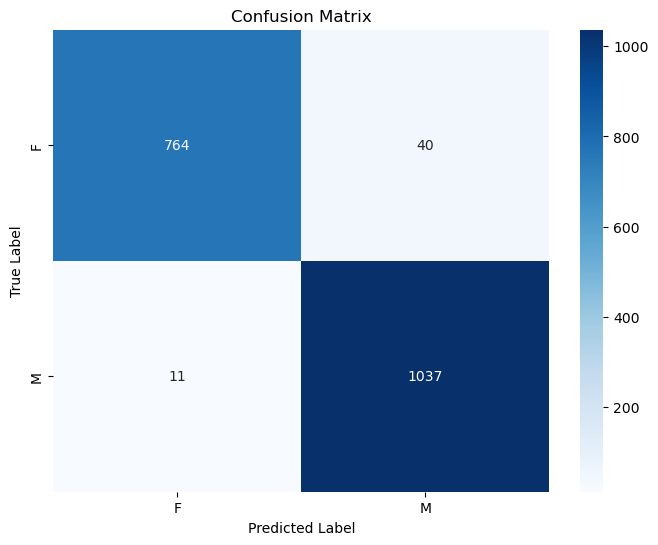

In [40]:
import seaborn as sns

conf_matrix = confusion_matrix(y_test, predictions)

# Top row: true F predicted F, then predicted M
print(conf_matrix)

class_labels = ['F', 'M']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels = class_labels, yticklabels = class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


## ROC and auROC

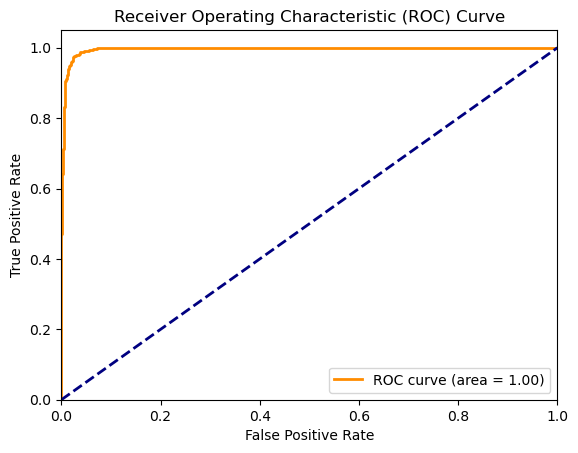

In [41]:
# Assuming y_true contains the true labels and y_scores contains the predicted scores
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label='M')
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Precision-recall curve

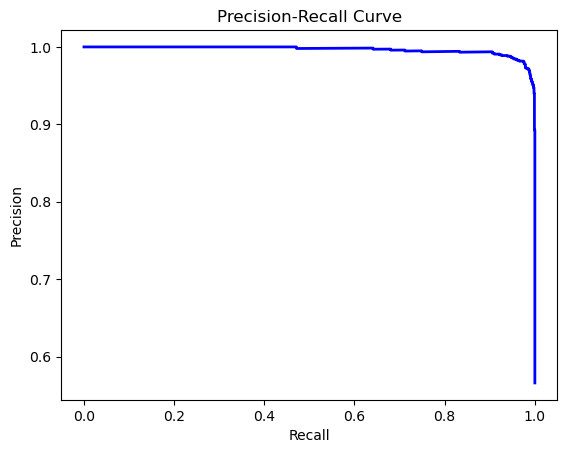

In [42]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label = 'M')

# Plotting precision-recall curve
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Test on unlabeled part of dataset

In [43]:
data = adata_unlabeled.X.toarray()[:, adata_unlabeled.var.index.isin(prelim_model_features)]


one_hot_encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
target_sex = adata_unlabeled.obs.Sex
target_sex_encoded = one_hot_encoder.fit_transform(target_sex.astype('category').values.reshape(-1, 1))


In [44]:
# Generate predictions
predictions = best_model.predict(data)

y_scores = best_model.decision_function(data)  # This gives you the decision scores of the classifier



In [45]:
adata_unlabeled.obs['predicted_sex'] = predictions

In [46]:
adata_unlabeled.obs

,sample_ids,PRESENT_raw,sample_ids_letter,SampleID,True ID,Litter,Pooled,Genotype,Condition,Group,...,total_counts_gene_hsp,pct_counts_gene_hsp,total_counts_gene_ribo,pct_counts_gene_ribo,total_counts_gene_hemo,pct_counts_gene_hemo,n_genes,leiden_labeled,Sex_Celltype,predicted_sex
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGCAGCGTA-1-F_filtered_gene_bc_matrices,F_filtered_gene_bc_matrices,True,F,F,7011 #7-5 (F) and 7011 #7-4 (M),7011_7,Y,WT,LPS,WT.LPS,...,123.0,1.049846,2133.0,18.205872,4.0,0.034141,3824,Radial Glial Cell,Unknown_Radial Glial Cell,M
AAACCTGAGCGATCCC-1-F_filtered_gene_bc_matrices,F_filtered_gene_bc_matrices,True,F,F,7011 #7-5 (F) and 7011 #7-4 (M),7011_7,Y,WT,LPS,WT.LPS,...,115.0,1.098901,1898.0,18.136646,5.0,0.047778,3674,Radial Glial Cell,Unknown_Radial Glial Cell,F
AAACCTGAGCTGAACG-1-F_filtered_gene_bc_matrices,F_filtered_gene_bc_matrices,True,F,F,7011 #7-5 (F) and 7011 #7-4 (M),7011_7,Y,WT,LPS,WT.LPS,...,89.0,0.789427,2000.0,17.739933,11.0,0.097570,3725,Radial Glial Cell,Unknown_Radial Glial Cell,F
AAACCTGAGGCGACAT-1-F_filtered_gene_bc_matrices,F_filtered_gene_bc_matrices,True,F,F,7011 #7-5 (F) and 7011 #7-4 (M),7011_7,Y,WT,LPS,WT.LPS,...,184.0,1.251020,2896.0,19.689964,9.0,0.061191,4143,Radial Glial Cell,Unknown_Radial Glial Cell,M
AAACCTGCAGCTCGCA-1-F_filtered_gene_bc_matrices,F_filtered_gene_bc_matrices,True,F,F,7011 #7-5 (F) and 7011 #7-4 (M),7011_7,Y,WT,LPS,WT.LPS,...,284.0,0.857902,4576.0,13.823102,9.0,0.027187,6809,Radial Glial Cell,Unknown_Radial Glial Cell,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTGCATCTA-1-G_filtered_gene_bc_matrices,G_filtered_gene_bc_matrices,True,G,G,7011 #7-9 (F) and 7011 #7-3 (M),7011_7,Y,HET,LPS,HET.LPS,...,138.0,0.920368,2286.0,15.246098,7.0,0.046685,4262,Intermediate Progenitor Cell,Unknown_Intermediate Progenitor Cell,M
TTTGTCAGTTCTCATT-1-G_filtered_gene_bc_matrices,G_filtered_gene_bc_matrices,True,G,G,7011 #7-9 (F) and 7011 #7-3 (M),7011_7,Y,HET,LPS,HET.LPS,...,220.0,1.113642,3654.0,18.496584,7.0,0.035434,4945,Radial Glial Cell,Unknown_Radial Glial Cell,M
TTTGTCATCATGTCTT-1-G_filtered_gene_bc_matrices,G_filtered_gene_bc_matrices,True,G,G,7011 #7-9 (F) and 7011 #7-3 (M),7011_7,Y,HET,LPS,HET.LPS,...,205.0,1.107869,4816.0,26.026806,9.0,0.048638,4402,Radial Glial Cell,Unknown_Radial Glial Cell,M


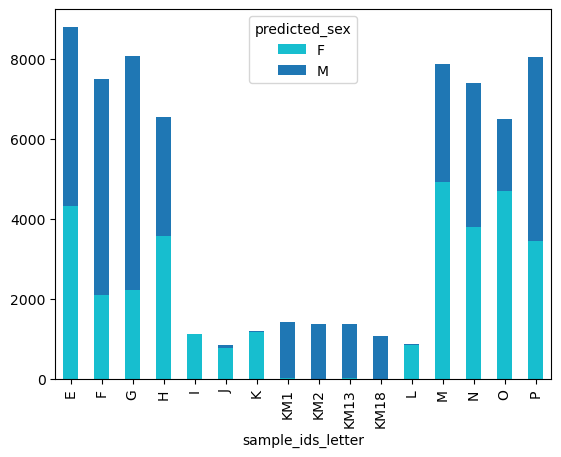

In [47]:
# Visualize proportional cell abundance in predictions to get a better sense for error
adata_all = adata_unlabeled.concatenate(adata_labeled, 
                              batch_key='sample_ids')


col_levels = adata_all.obs['predicted_sex'].unique()

vis_meta_cellcount_stacked_bar(adata_all, meta_col='predicted_sex', 
                                dict_colors = dict(zip(col_levels, cm.get_cmap("tab10", len(col_levels)).colors )) )

In [56]:
# TODO: find actual counts of cells added from each individual to a sample to get better estimates on what the M/F ratio should be in samples
adata_all.obs.groupby(['SampleID'])['predicted_sex'].apply(lambda x: (x == 'M').mean() * 100)

SampleID
E       50.977051
F       71.905908
G       72.433908
H       45.275229
I        1.426025
J        8.820024
K        1.595298
KM1     99.438990
KM2     99.852941
KM13    98.980335
KM18    99.721448
L        1.836969
M       37.557252
N       48.791357
O       27.529303
P       57.318588
Name: predicted_sex, dtype: float64